##  고급 회기 실습 : 캐글 주택 가격 회기 분석

### 사용 데이터 
데이터 다운로드  
https:www.kaggle.com  
house 검색  


---
house_price 데이터
- 1460개의 레코드(행, 건), 81개의 피처로 구성  
- 미국 아이오와 주의 에임즈(Ames) 지방의 주택 가격 정보 데이터

### 전체 회귀 분석 과정
1. 데이터 전처리 : Null, target 값 로그 변환, 원-핫 인코딩  
2. 선형 회귀 모델 : LinearRegression, Ridge, Lasso  
   (1) 학습/예측/평가   
   (2) 모델별 회귀 계수 시각화  
   (3) 교차 검증 수행   
   (4) 하이퍼 파라미터 튜닝 후 재학습 / 예측 / 평가  
3. 피처 데이터 변환  
   (1) 왜곡도 / 피처 데이터 로그 변환 / 원-핫 인코딩  
   (2) 모델 학습/예측/평가   
   (3) 모델별 회귀 계수 시각화  
   (4) 이상치 처리  
   (5) 릿지 / 라쏘 모델 최적화 수행  
4. 회귀 트리 모델  : LightGBM   
   (1) 학습/예측/평가   
   (2) 피처 중요도 시각화  
5. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
   -  릿지 모델(40%)과 라쏘 모델(60%) 혼합  


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

### 1.  데이터 전처리
- Null 값 처리, target 값 로그 변환, 원-핫 인코딩   

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('./data/house_price.csv')
# 가공 작업 중에 원본 데이터 필요
# 원본 데이터 유지하기 위해, 복사본으로 가공 작업 진행 
house_df = house_df_org.copy()
house_df.head()
house_df.tail()

# Target 값 : SalePrice (주택 가격) (마지막 칼럼)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


주요 피처들

- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet      
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet      
- GarageArea: Size of garage in square feet      
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	  
- OverallCond: Rates the overall condition of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average	  
       5	Average  
       4	Below Average	  
       3	Fair  
       2	Poor  
       1	Very Poor  
- YearBuilt: Original construction date  
- Neighborhood: Physical locations within Ames city limits  
   Blmngtn  Bloomington Heights  
   Blueste  Bluestem  
   BrDale   Briardale  
   .....

- RoofMatl: Roof material  
	ClyTile	Clay or Tile  
	CompShg	Standard (Composite) Shingle  
	Membran	Membrane  
	Metal	Metal  
	.....

- RoofStyle: Type of roof  
	Flat	Flat  
	Gable	Gable  
	Gambrel	Gabrel (Barn)  
	.....

## 데이터 특성 파악
- 특성 설명 : features(컬럼) 설명 자료 필요함 (도메인지식이 분석에 아주 중요함)
---
SalePrice: 판매가격(달러), 목적변수(예측하려는 대상 변수)  
MSSubClass : 건물 클래스  
MSZoning : 일반 구역 분류  
LotFrontage : 부동산에 연결된 거리의 선형 피트  
LotArea : 평방 피트 단위의 부지 크기  
Street : 도로 접근 유형  
Alley : 골목 접근 방식  
LotShape : 속성의 일반적인 모양  
LandContour : 부동산의 평탄도  
Utilities : 사용 가능한 유틸리티 유형  
LotConfig : 로트 구성  
LandSlope : 속성의 기울기  
Neighborhood : Ames 시 경계 내의 물리적 위치  
Condition1 : 간선도로 또는 철도와 인접  
Condition2 : 간선도로 또는 철도와의 근접성(초가 있는 경우)  
BldgType : 주거 유형  
HouseStyle : 주거 스타일  
OverallQual : 전체재질 및 마감품질  
OverallCond : 전체 상태 등급  
YearBuilt : 원래 건설 날짜  
YearRemodAdd : 리모델링 날짜  
RoofStyle : 지붕 유형  
RoofMatl : 지붕 재료  
ExterQual1st : 주택의 외부 피복  
ExterQual2nd : 주택의 외부 덮음(하나 이상의 재료인 경우)  
MasVnrType : 석조 베니어 유형  
MasVnrArea : 석조 베니어판 면적(제곱피트)  
ExterQual : 외장재 품질  
ExterCond : 외장재의 현황  
Foundation : 기반의 종류  
BsmtQual : 지하실 높이  
BsmtCond : 지하실의 일반 상태  
BsmtExposure : 파업 또는 정원 수준의 지하 벽  
BsmtFinType1 : 지하실 마감 면적의 품질  
BsmtFinSF1 : 1종 제곱피트 완성  
BsmtFinType2 : 두 번째 완성 영역의 품질(있는 경우)  
BsmtFinSF2 : 유형 2 완성 평방 피트  
BsmtUnfSF : 지하실의 미완성 평방 피트  
TotalBsmtSF : 지하실의 총 평방 피트  
Heating : 난방의 종류  
HeatingQC : 난방 품질 및 상태  
CentralAir : 중앙 에어컨  
Electrical : 전기 시스템  
1stFlrSF : 1층 평방피트  
2ndFlrSF : 2층 평방피트  
LowQualFinSF : 저품질 마감 평방 피트(모든 층)  
GrLivArea : 지상(지상) 거실 면적 평방피트  
BsmtFullBath : 지하 전체 욕실  
BsmtHalfBath : 지하 반 화장실  
FullBath : 등급 이상의 전체 욕실  
HalfBath : 등급 이상의 반욕  
Bedroom : 지하층 이상의 침실 수  
kitchen : 주방 수  
KitchenQual : 주방 품질  
TotRmsAbvGrd : 등급 이상의 총 방(화장실 제외)  
Functional : 홈 기능 등급  
Fireplaces : 벽난로의 수  
FireplaceQu : 벽난로 품질  
GarageType : 차고 위치  
GarageYrBlt : 차고 건설 연도  
GarageFinish : 차고 인테리어 마감  
GarageCars : 차고의 차고 크기  
GarageArea : 평방 피트의 차고 크기  
GarageQual : 차고 품질  
GarageCond : 차고 상태  
PavedDrive : 포장된 차도  
WoodDeckSF : 평방 피트의 목재 데크 면적  
OpenPorchSF : 평방 피트의 오픈 베란다 영역  
EnclosedPorch : 평방 피트의 닫힌 베란다 영역  
3SsnPorch : 제곱피트의 3계절 베란다 면적  
ScreenPorch : 평방 피트의 스크린 베란다 면적  
PoolArea : 평방 피트의 수영장 면적  
PoolQC : 수영장 품질  
Fence : 울타리 품질  
MiscFeature : 다른 범주에서 다루지 않는 기타 기능  
MiscVal : 기타 기능의 $값  
MoSold : 월 판매  
YrSold : 판매 연도  
SaleType : 판매유형  
SaleCondition : 판매조건 

#### 데이터 확인

데이터 확인 결과
- 1460개의 레코드(행, 건), 81개의 피처로 구성
- 피처 타입 : 문자형(object), 숫자형(정수(int), 실수(float))
- Target을 제외한 80개의 피처 중 43개 문자형, 나머지 숫자형
- 데이터 양에 비해 Null 값이 많은 피처 존재
- 1,000개가 넘는 데이터가 Null 인 피처도 존재
- Null이 너무 많은 피처는 drop할 것임

### 회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인


### 로그 변환 및 환원
- 정규 분포가 아닌 결과값을 정규 분포 형태로 변환  
- 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법이 로그 변환    
- log1p() 이용해 로그 변환한 결과값을 기반으로 학습한 후  
- 예측 시 다시 결과값을 expm1()으로 환원해서 사용  
 

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='SalePrice', ylabel='Count'>

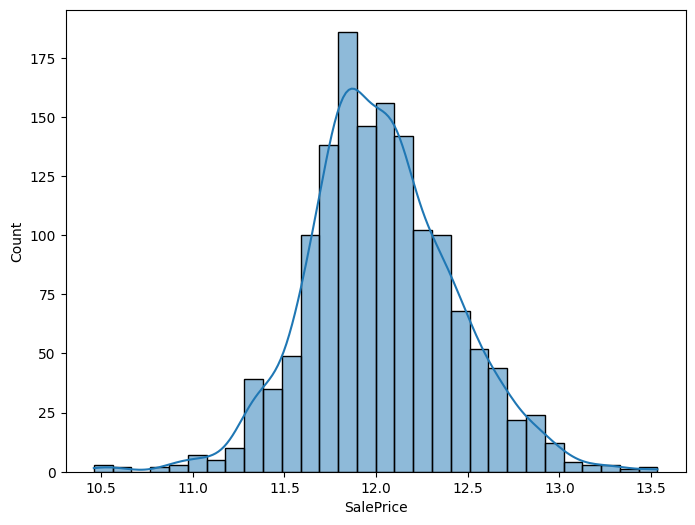

C:\Users\student\AppData\Local\Temp\ipykernel_15372\4062695360.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(SalePrice_Log, fit=stats.norm)


<Axes: xlabel='SalePrice', ylabel='Density'>

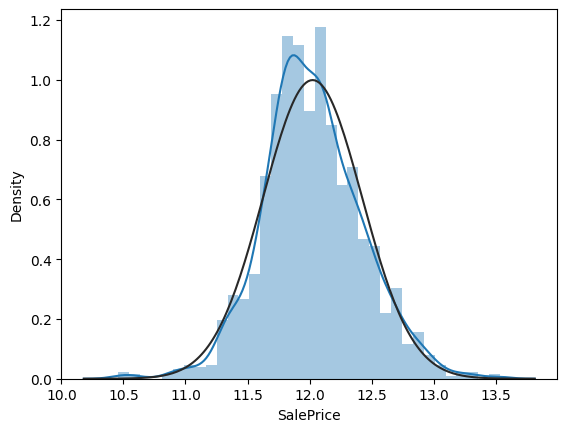

In [ ]:
from scipy import stats



### 데이터 확인 후 : 로그 변환 및 Null 처리
- 숫자형 피처에 대해 
    - Null이 너무 많은 피처는 삭제  
    - 기타 숫자형 Null값은 평균값으로 대체  

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016


In [10]:
# Null 이 너무 많은 피처와
# PoolQC          1453
# MiscFeature     1406
# Alley           1369
# Fence           1179
# MasVnrType       872
# FireplaceQu      690

In [11]:
# Null 이 너무 많은 피처와 불필요한 피처 삭제 
# ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']

column_names = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']
house_df.drop(column_names, axis=1, inplace=True)
house_df.shape

(1460, 74)

In [ ]:
# 삭제하지 않은 숫자형 Null 피처들은 평균값으로 대체


In [ ]:
# Null 처리 후 확인 : Null 값이 있는 피처명과 타입 추출


BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

### 카테고리 값의 문자열 변환
- **ML 알고리즘에서 문자열 값을 입력 값으로 허용하지 않음**
- 인코딩 처리하여 숫자형으로 변환


### 머신러닝의 대표적인 인코딩 방식
- 레이블 인코딩 (Label Encoding)
- 원-핫 인코딩 (One-Hot-Encoding)


In [ ]:
# 원-핫 인코딩 수행 : house_df_ohe로 저장 


원-핫 인코딩 수행 전 :  (1460, 74)
원-핫 인코딩 수행 후 :  (1460, 267)


In [ ]:
# Null 값을 가진 피처 확인


Series([], dtype: object)

### 전처리 작업 완료 
- 종속 변수(타깃값 : SalePrice)는 로그 변환 
- Null 이 너무 많은 피처는 삭제 (7개 피처 삭제)    
- 나머지 숫자형 피처의 결측값은 평균값으로 대체   
- 문자형 피처는 원-핫 인코딩 진행 (피처수 74 -> 267)   
      - 원-핫 인코딩 진행 후 피처수 너무 많이 증가한 경우     
      - 예측 진행한 후 결과가 너무 안 좋으면 피처수를 줄여야 함 (다양한 방법 시도) 

### 2. 선형 회귀 모델 : LinearRegression, Ridge, Lasso  

### (1) 학습/예측/평가

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# 평가 함수 작성

# 학습된 모델을 받아서 예측하고 RMSE 반환

# (1) 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습한 모델 전달 받아서 

    
    print(f"{model.__class__.__name__} RMSE : {rmse:.3f}")
    print(f'R제곱 : {r2_score(y_test, y_pred):.3f}')
    
    return rmse


# (2) 여러 모델의 RMSE 값 반환 : 1번 함수 호출
def get_rmses(models):

    
    return rmses

In [17]:
from sklearn.model_selection import train_test_split

# 데이터 준비  : 원-핫 인코딩된 데이터 세트 사용 : house_df_ohe 사용

y_target = house_df_ohe['SalePrice']
X_feature = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)


# 학습/테스트 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_feature ,
                                                       y_target ,
                                                       test_size=0.2, 
                                                       random_state=156)

### 모델 생성/학습/예측/평가 

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 선형 계열의 회귀 모델 생성 및 학습
# LinearRegression / Ridge / Lasso



LinearRegression()

Ridge()

Lasso()

In [ ]:
# 평가 함수 호출 / 결과 출력 


# 결과
# LinearRegression RMSE : 0.132
# R제곱 : 0.896
    
# Ridge RMSE : 0.127
# R제곱 : 0.902

# Lasso RMSE : 0.176
# R제곱 : 0.813

# 3개 모델 전부 성능이 좋게 나왔음
# RMSE 수치는 Ridge가 가장 낮게 나왔고 Lasso가 가장 높게 출력됨 : RMSE는 낮을수록 좋음
# 라쏘가 타 회귀 모델보다 성능이 더 떨어지는 결과 
# --> 추후 하이퍼 파라미터 튜닝을 진행해서 확인 필요
# --> 최적의 하이퍼 파라미터 찾고
# --> 릿지와 라쏘 모델에 대해 수행

# 먼저, 피처별 회귀 계수를 시각화해서
# 모델별로 어떤 피처의 회귀 계수로 구성되는지 확인 

LinearRegression RMSE : 0.132
R제곱 : 0.896
Ridge RMSE : 0.127
R제곱 : 0.902
Lasso RMSE : 0.176
R제곱 : 0.813


[0.13170346544397304, 0.127430577842106, 0.17628250556471398]

### (2) 모델별 회귀 계수 시각화

In [ ]:
# 피처 수가 많으므로 회귀 계수 값의
# 상위 10개, 하위 10개의 피처명과 회귀 계수값을 반환하는 함수 작성
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체 생성 (회귀 계수와 피처명)
    # index는 피처명(컬럼명)

    
    # + 상위 10개, - 하위 10개 회귀 계수 추출하여 반환

    
    return coef_high, coef_low

In [64]:
# 모델별 회귀 계수 시각화하는 함수
# list 객체로 모델을 입력받아서
# 모델별 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태 출력

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)    
        
        # if coef_high.empty or coef_low.empty:             
        #     print(f"{model.__class__.__name__}: Coefficients are empty. Skipping plot.") 
        #     continue # 계수가 없으면 건너뜀
       
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)        
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num] )
    plt.show()

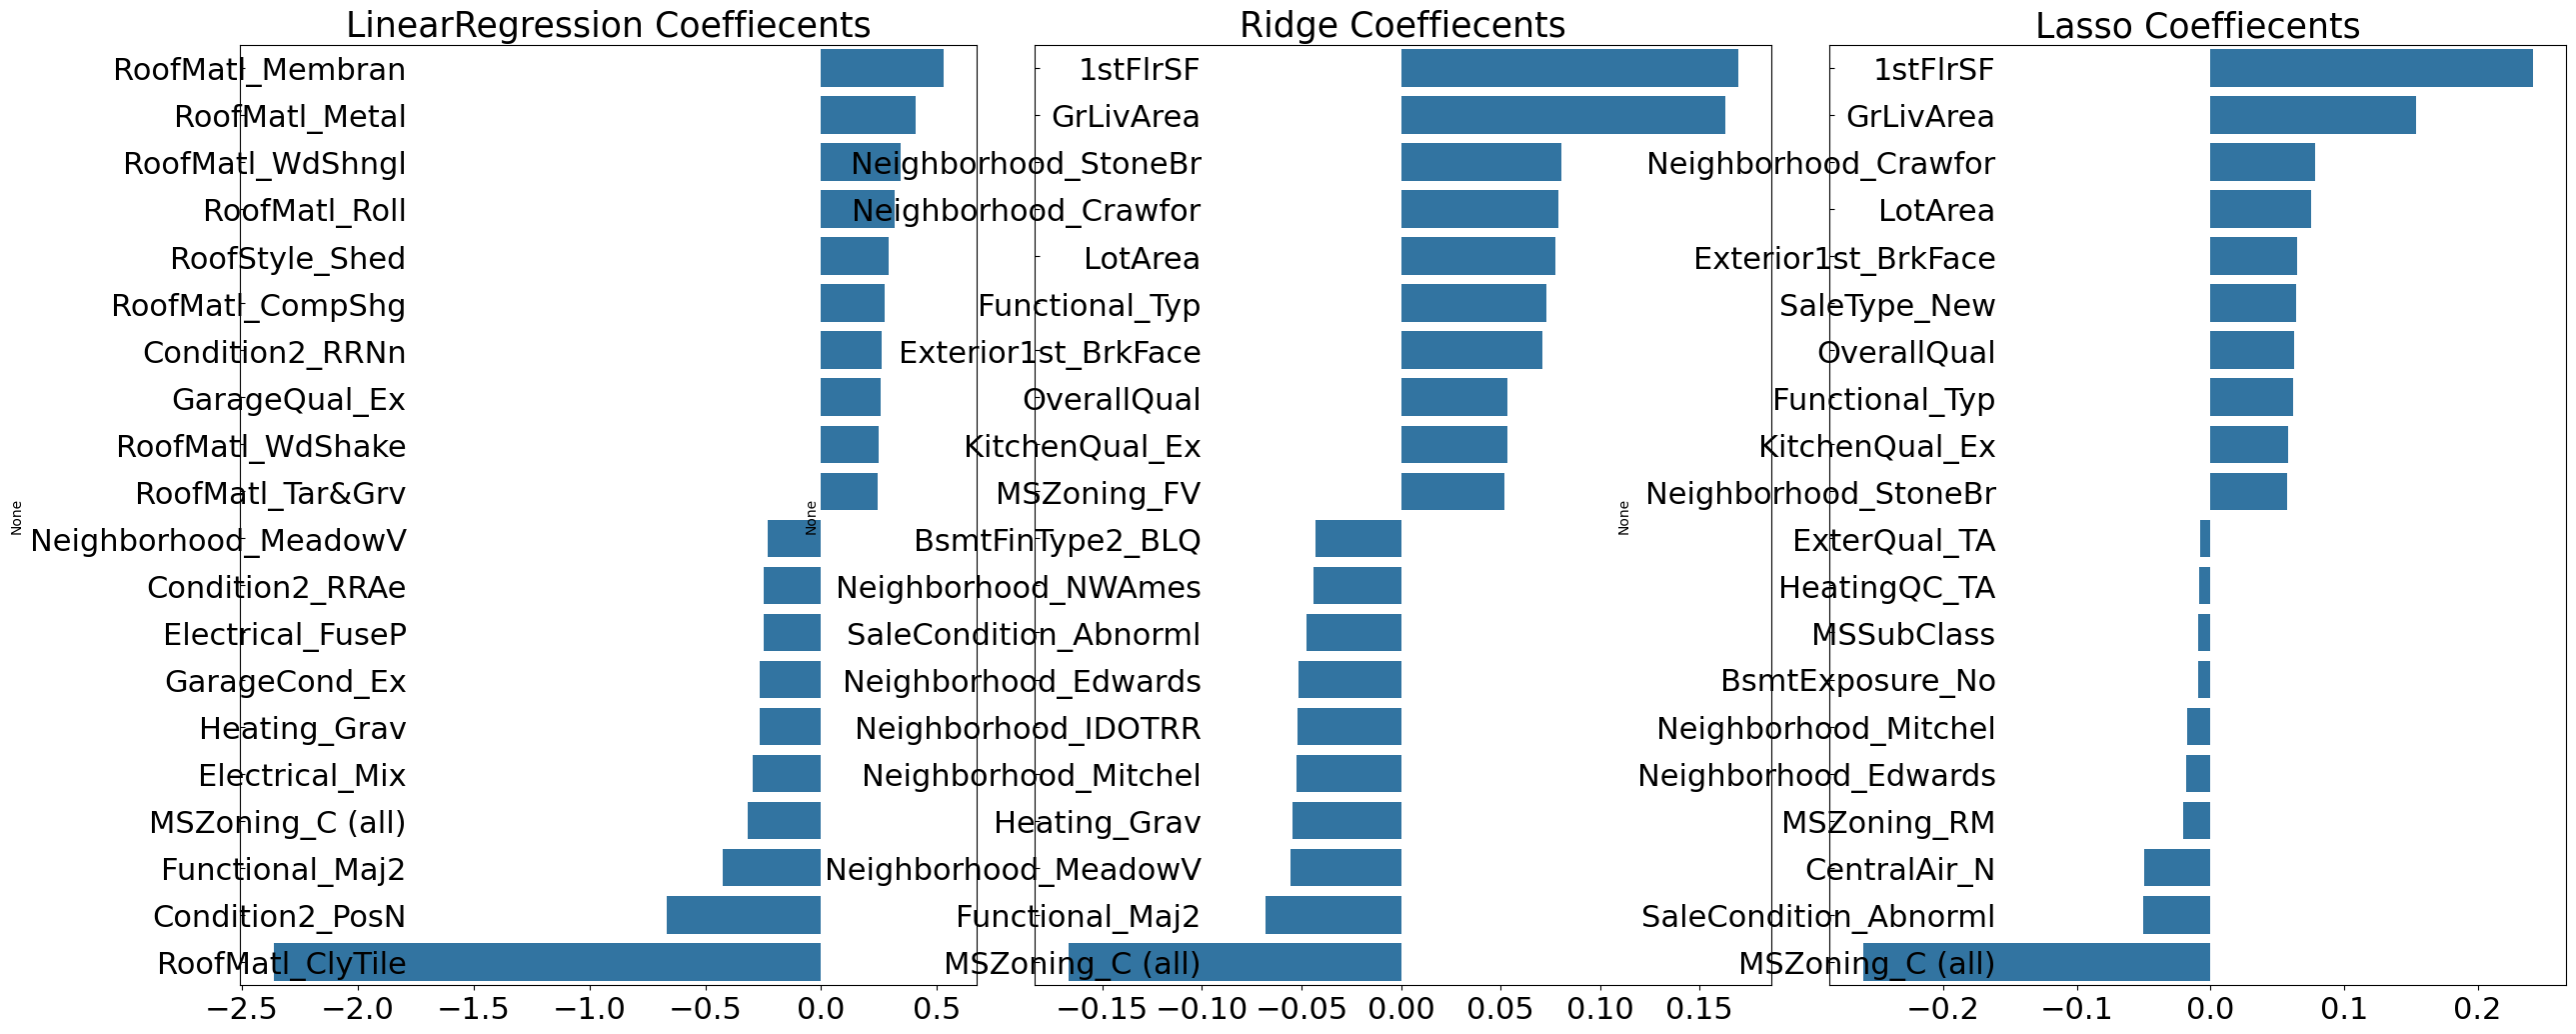

In [65]:
# 시각화 함수 호출 : 모델별 결과 출력 
visualize_coefficient([lr_reg, ridge, lasso])

# 결과
# 각 모델별 상위, 하위 10개의 회귀 계수를 확인한 결과
# LinearRegression과 Ridge : 피처 종류와 회귀 계수가 유사한 형태로 분포

# Lasso : 전체적으로 피처 종류도 차이가 있고, 회귀 계수 값이 매우 작음 
# - YearBuilt가 가장 크고, 다른 피처와 회귀 계수는 너무 작음
# -> 혹시 학습 데이터 분할에 문제가 있어서 그런 것인지
# -> 교차검증을 진행하여 평균 RMSE를 확인 필요

### (3) 교차 검증 수행

In [ ]:
from sklearn.model_selection import cross_val_score

# 5개 폴드 교차검증으로 모델별 RMSE와 평균 RNSE 출력

# 교차검증 수행하는 함수 작성
def rmse_avvg_cv(models):
    for model in models:

        print(f"{model.__class__.__name__} 교차검증 RMSE : {rmse_list}")
        print(f"{model.__class__.__name__} 교차검증 평균 RMSE : {rmse_avg:.3f}")
    
    
# 함수 호출하고 회귀 모델 전달해서 결과 출력 



# 교차검증 결과

# LinearRegression  : 평균 RMSE : 0.155
# Ridge  : 평균 RMSE : 0.144
# Lasso : 평균 RMSE : 0.198

# 여전히 라소의 경우 LinearRegression과 Ridge 모델 보다 성능이 약간 떨어짐
# --> 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키면서 최적값 도출해서 확인 
# --> GridSearchCV 하이퍼 파라미터 튜닝 수행 


# 교차검증 수행 전
# LinearRegression RMSE : 0.132
# Ridge RMSE : 0.127
# Lasso RMSE : 0.176


LinearRegression 교차검증 RMSE : [0.11438336 0.12906723 0.14141516 0.11231756 0.11786209]
LinearRegression 교차검증 평균 RMSE : 0.123
Ridge 교차검증 RMSE : [0.10278081 0.1187697  0.12175701 0.10440189 0.11389941]
Ridge 교차검증 평균 RMSE : 0.112
Lasso 교차검증 RMSE : [0.10301103 0.11674084 0.12235937 0.10568739 0.11220215]
Lasso 교차검증 평균 RMSE : 0.112


### (4) 하이퍼 파라미터 튜닝 후 재학습 / 예측 / 평가 

In [ ]:
# 릿지와 라쏘 모델의 alpha 값을 변화시키면서 하이퍼 파라미터 튜닝 수행 

from sklearn.model_selection import GridSearchCV

# 튜닝 수행 함수 작성
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error',
                             cv=5)
    grid_model.fit(X_feature, y_target)
    rmse = np.sqrt(-1 * )
     # 최적 평균 RMSE 값 출력 , 최적 alpha 값 
    print(f"{model.__class__.__name__} 최적 평균 RMSE : {rmse:.4f}, 최적 alpha {}")   
    
    return 

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

best_ridge = get_best_params(ridge, ridge_params)
best_lasso = get_best_params(lasso, lasso_params)    


# GridSearchCV 적용 결과
# 릿지 모델 : 'alpha': 10에서 최적 평균 RMSE : 0.1417
# 라쏘 모델 : 'alpha': 0.001에서 최적 평균 RMSE : 0.1420


# 라소 알파로 0.0005 더 성능 좋음 
# Lasso RMSE : 0.119
# R제곱 : 0.914


# alpha 값 튜닝 전 
# Ridge  : 평균 RMSE : 0.144
# Lasso : 평균 RMSE : 0.198

# 라쏘 모델 : alpha 값 최적화 후 예측 성능이 많이 좋아짐 : 0.198 -> 0.142
# 릿지 모델 : 큰 차이는 없지만 조금이나마 성능이 향상됨 : 0.144 -> 0.1417

Ridge 최적 평균 RMSE : 0.1126, 최적 alpha {'alpha': 8}
Lasso 최적 평균 RMSE : 0.1122, 최적 alpha {'alpha': 0.001}


### 최적의 alpha 값으로 학습 / 예측 / 평가 

Ridge(alpha=10)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.471
R제곱 : -0.380
Ridge RMSE : 0.103
R제곱 : 0.934
Lasso RMSE : 0.100
R제곱 : 0.938


[0.47115370344802354, 0.10301715994244488, 0.10023723657391549]

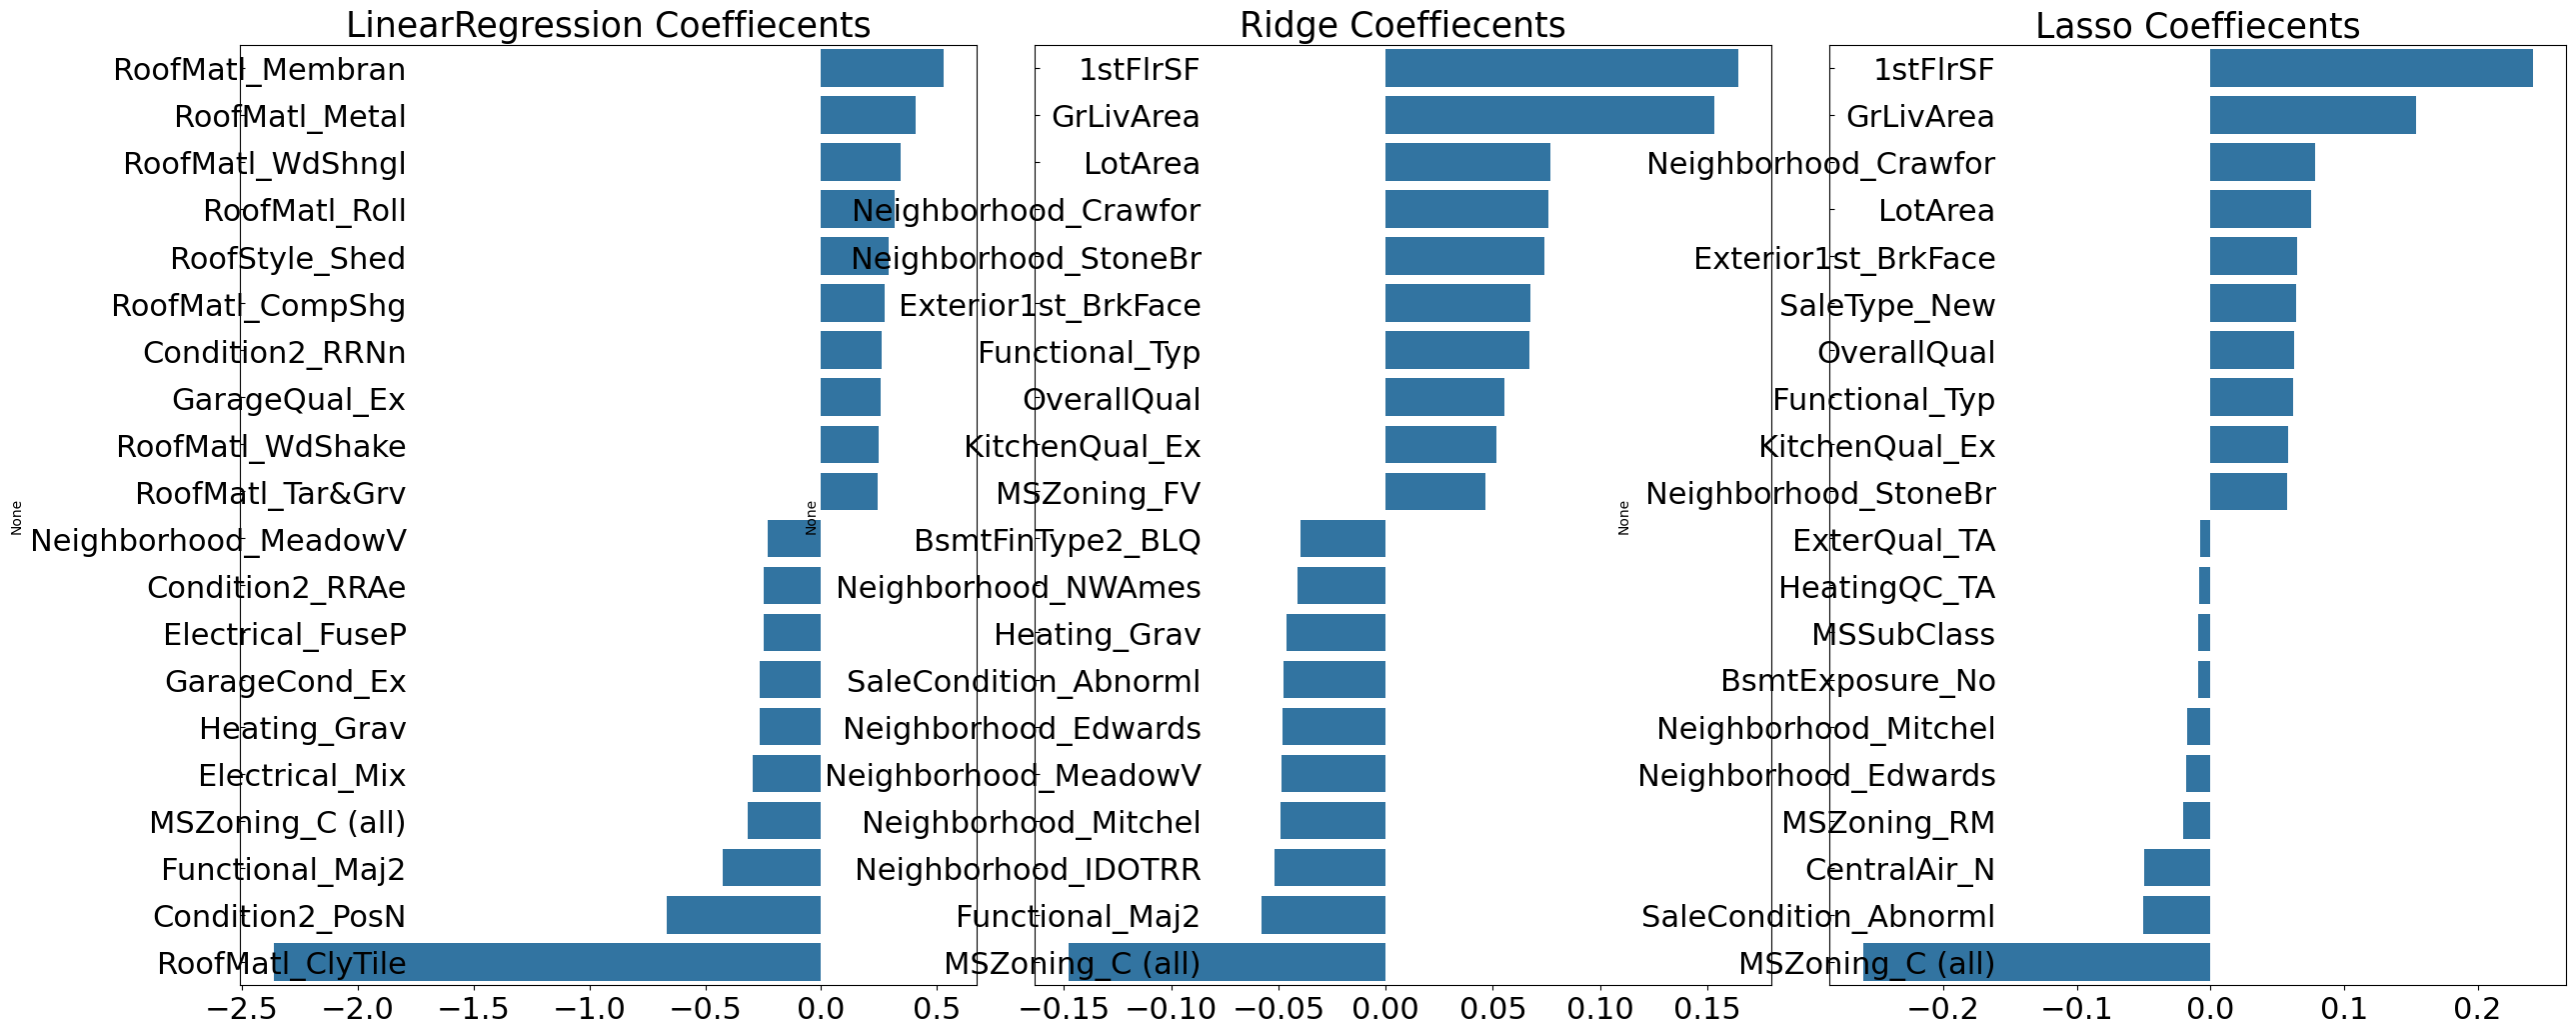

### 지금까지는 target 값에 대해서만 데이터 분포 확인하고 로그 변환 수행 

In [26]:
############################################################################

## 3. 피처 데이터 변환

### 추가 가공 작업 진행 후 모델 튜닝 좀 더 진행 
- (1) 피처 데이터 세트의 데이터 분포도 확인  
- (2) 이상치 데이터 처리

### (1) 피처 데이터 세트의 데이터 분포도 확인
- 앞에서 타깃 데이터(종속 변수) 세트의 데이터 분포도의 왜곡 확인했음
- 피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우
- 회귀 예측 성능 저하 가능
- 모든 숫자형 피처의 데이터 분포도 확인해서 왜곡 정도 확인
- 왜곡도 높은 피처들은 로그 변환 수행


#### 왜곡된 정도 추출
- 사이파이 status 모듈의 skew() 함수 사용
    - 일반적으로 skew() 함수 반환 값이 1 이상인 경우 
    - 왜곡도가 높다고 판단  
- 주의 : 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 제외
    - 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높음

### (1) 왜곡도 / 피처 데이터 로그 변환 / 원-핫 인코딩
- 피처 중 왜곡도가 심한 피처를 로그 변환  

In [ ]:
# 숫자형 피처들에 대한 데이터 분포 왜곡도 확인 후
# 높은 왜곡도를 나타내는 피처 추출하고
# 왜곡도 값이 1 이상인 경우 높다고 판단 
# 왜곡도 높은 피처들에 대해 로그 변환 적용

# 주의!
# 앞에서 원-핫 인코딩 적용된 house_df_ohe 데이터의 
# 숫자형 피처들 중에는 문자형 피처가 원-핫 인코딩된 피처들이 포함되어 있음
# 숫자형 변수의 왜곡도 확인은
# 원-핫 인코딩 적용 전 데이터 house_df 사용

from scipy.stats import skew

# object가 아닌 숫자형 피처 index 추출


# skew() 적용
# apply lambda로 skew() 호출


# skew 정도가 1 보다 큰 피처들만 추출


# 결과
# 일반적으로 skew 정도의 값이 1이상인 또는 1.5 이상인 경우 왜곡도가 높다고 판단하지만
# 상황에 따라 편차는 있음

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64

In [70]:
house_df.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699
1,3.044522,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016


#### 로그 변환

In [71]:
skew_features_top.index

Index(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [72]:
# 왜곡도가 높은 피처들을 로그 변환
# skew 정도가 1이상인 피처들

house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])
house_df[skew_features_top.index]

,BsmtFinSF2,LowQualFinSF,BsmtHalfBath,KitchenAbvGr,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0.000000,0.0,0.000000,0.526589,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.526589,0.526589,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.000000,0.526589,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.526589,1.888504,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.526589,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
1455,0.000000,0.0,0.000000,0.526589,0.000000,0.0,0.0,0.0,0.000000
1456,1.808267,0.0,0.000000,0.526589,0.000000,0.0,0.0,0.0,0.000000
1457,0.000000,0.0,0.000000,0.526589,0.000000,0.0,0.0,0.0,2.177526
1458,2.071575,0.0,0.000000,0.526589,1.745260,0.0,0.0,0.0,0.000000


In [ ]:
# 로그 변환 후 다시 왜곡 정도 확인
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew 정도가 1 보다 큰 피처들만 추출
skew_features_top = skew_features[skew_features > 1]
skew_features_top.sort_values(ascending=False)



PoolArea         14.339852
3SsnPorch         7.638944
LowQualFinSF      7.330902
MiscVal           5.036720
BsmtHalfBath      3.888823
ScreenPorch       3.118480
KitchenAbvGr      2.954603
BsmtFinSF2        2.446157
EnclosedPorch     2.062641
dtype: float64

### (2) 모델 학습/예측/평가
- 원-핫 인코딩 적용 후 최적 하이퍼 파라미터 튜닝 후 평가 지표 확인

In [74]:
# skew가 높은 피처들을 로그 변환했으므로
# 다시 원-핫 인코딩 적용
# 피처/타깃 데이터 세트 다시 생성
# 최적 alpha 값과  RMSE 출력


# 원-핫 인코딩 
house_df_ohe2 = pd.get_dummies(house_df)

# 타깃/피처 데이터 세트 생성
y_target = house_df_ohe2['SalePrice']
X_feature = house_df_ohe2.drop('SalePrice', axis=1)


In [75]:
# 학습/테스트용 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_feature ,
                                                       y_target ,
                                                       test_size=0.2, 
                                                       random_state=156)

# 다시 최적 하이퍼 파라미터 튜닝 후 RMSE 출력 
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

best_ridge = get_best_params(ridge, ridge_params) # GridSearchCV 적용 함수 호출
best_lasso = get_best_params(lasso, lasso_params)    

# 결과 

# 피처 데이터 로그변환 전 (타깃값만 로그변환한 경우)

# GridSearchCV 적용 결과 (타깃값만 로그변환한 경우)
# Ridge RMSE : 0.124  R제곱 : 0.907
# Lasso RMSE : 0.120 R제곱 : 0.913

###################################################################

# 피처 데이터 로그변환 후
# 릿지 모델 : 'alpha': 10에서 최적 평균 RMSE : 0.1275
# 라쏘 모델 : 'alpha': 0.001에서 최적 평균 RMSE : 0.1252

# 피처 데이터 로그변환 후 
# 릿지와 라쏘 모두 약간의 성능이 향상되었음 

Ridge 최적 평균 RMSE : 0.1275, 최적 alpha {'alpha': 10}
Lasso 최적 평균 RMSE : 0.1251, 최적 alpha {'alpha': 0.001}


### (3) 모델별 회귀 계수 시각화  
- 모델의 학습/예측/평가 및 모델별 회귀 계수 시각화

Ridge(alpha=10)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.471
R제곱 : -0.337
Ridge RMSE : 0.121
R제곱 : 0.911
Lasso RMSE : 0.117
R제곱 : 0.917


[0.47128248931710215, 0.12146570507673381, 0.11720031635164761]

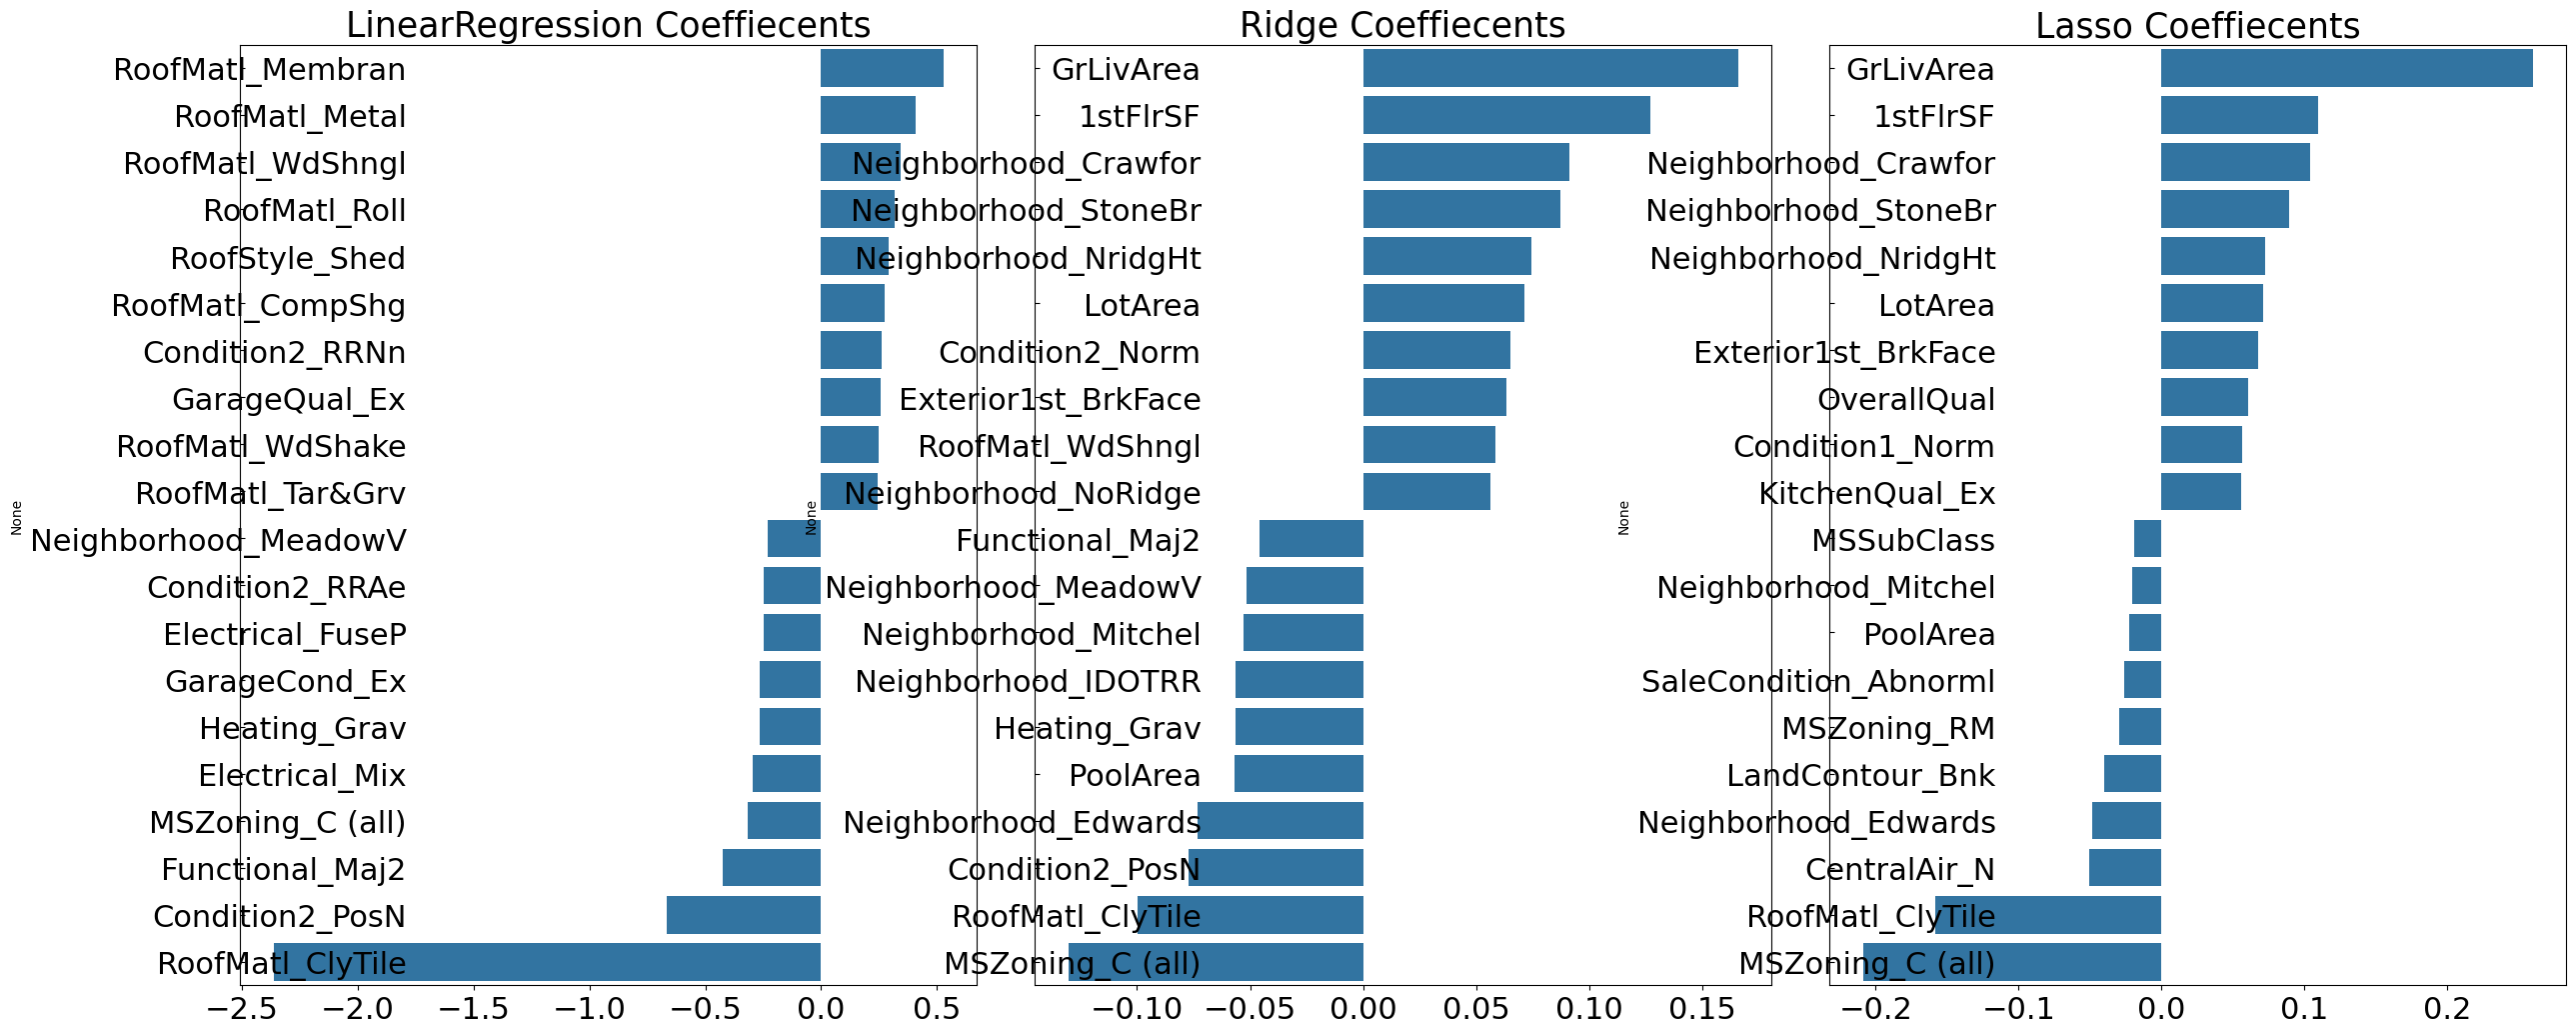

In [ ]:
# 최적화 alpha값으로 학습/예측/평가 수행
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])



### (4) 이상치 데이터 처리

다음으로 좀 더 분석할 요소는 이상치 데이터  
특히 회귀 계수가 높은 피처들은  
예측에 많은 영향을 미치는 중요 피처들이기 때문에  
이들 피처들의 이상치 데이터 처리가 중요함  

먼저 3개 모델 모두에서 가장 큰 회귀 계수를 가지는  
GrLivArea(주거 공간 크기) 피처의 데이터 분포 살펴 볼 것임

Text(0, 0.5, 'SalePrice')

Text(0.5, 0, 'GrLivArea')

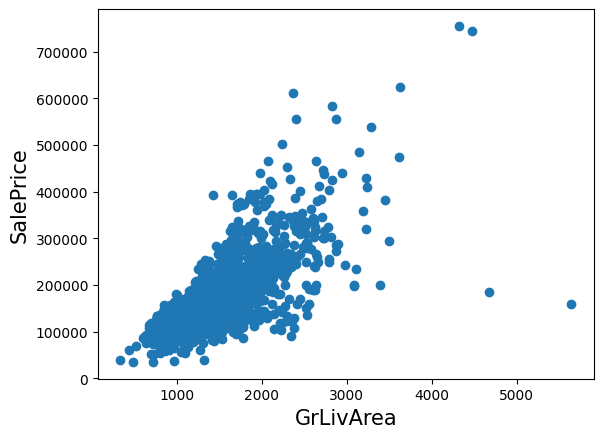

In [ ]:
# 이상치 데이터 검출을 위해 주요 피처인 GrLivArea(주거 공간 크기) 값에 대한 산포도 확인
# 주택 가격 데이터가 변환되기 이전의 원본 데이터 세트에서
# GrLivArea(주거 공간 크기) 와 타깃 값인 SalePrice의 관계 시각화

plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()



Text(0, 0.5, 'SalePrice')

Text(0.5, 0, 'GrLivArea')

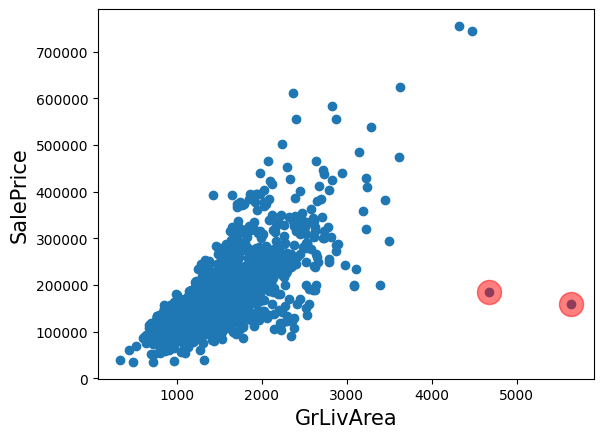

In [78]:
# 그래프에 확인한 이상치 표시
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)

outlier = (house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 500000)
outlier_df = house_df_org[outlier]
plt.scatter(x=outlier_df["GrLivArea"] , y=outlier_df["SalePrice"], s=300, c="r", alpha=0.5 )

plt.show()

In [ ]:
# 이상치 조건에 따라 이상치 제거
# 크기는 4000 보다 크고
# SalePrice는 500000 이하

# 주의! 지금 사용하는 데이터는 house_df_ohe2 (로그변환된 데이터)
# 4000과 500000도 로그변환해서 비교


print('이상치 삭제 전 :', house_df_ohe2.shape)

# 이상치 삭제


print('이상치 삭제 후 :', house_df_ohe2.shape)

# 2개 행 삭제됨

이상치 삭제 전 : (1460, 267)
이상치 삭제 후 : (1458, 267)


### (5) 릿지 / 라쏘 모델 최적화 수행 

In [ ]:
# 이상치 제거된 house_df_ohe2 데이터 사용

# 타깃/피처 데이터 세트 생성
y_target = house_df_ohe2['SalePrice']
X_feature = house_df_ohe2.drop('SalePrice', axis=1)

# 학습/테스트용 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_feature ,
                                                       y_target ,
                                                       test_size=0.2, 
                                                       random_state=156)

# 다시 최적 하이퍼 파라미터 튜닝 후 RMSE 출력 
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

best_ridge = get_best_params(ridge, ridge_params) # GridSearchCV 적용 함수 호출
best_lasso = get_best_params(lasso, lasso_params)    

# 최적의 alpha 값으로 튜닝하기 전 비교

# 릿지 모델 : alpha=10에서 최적 평균 RMSE : 0.1275 
# 라쏘 모델 : alpha=0.001에서 최적 평균  RMSE : 0.1252

# 이상치 제거 후


Ridge 최적 평균 RMSE : 0.1126, 최적 alpha {'alpha': 8}
Lasso 최적 평균 RMSE : 0.1122, 최적 alpha {'alpha': 0.001}


Ridge(alpha=8)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.463
R제곱 : -0.335
Ridge RMSE : 0.103
R제곱 : 0.934
Lasso RMSE : 0.100
R제곱 : 0.938


[0.46348347224263037, 0.10302426031214776, 0.09991870258961678]

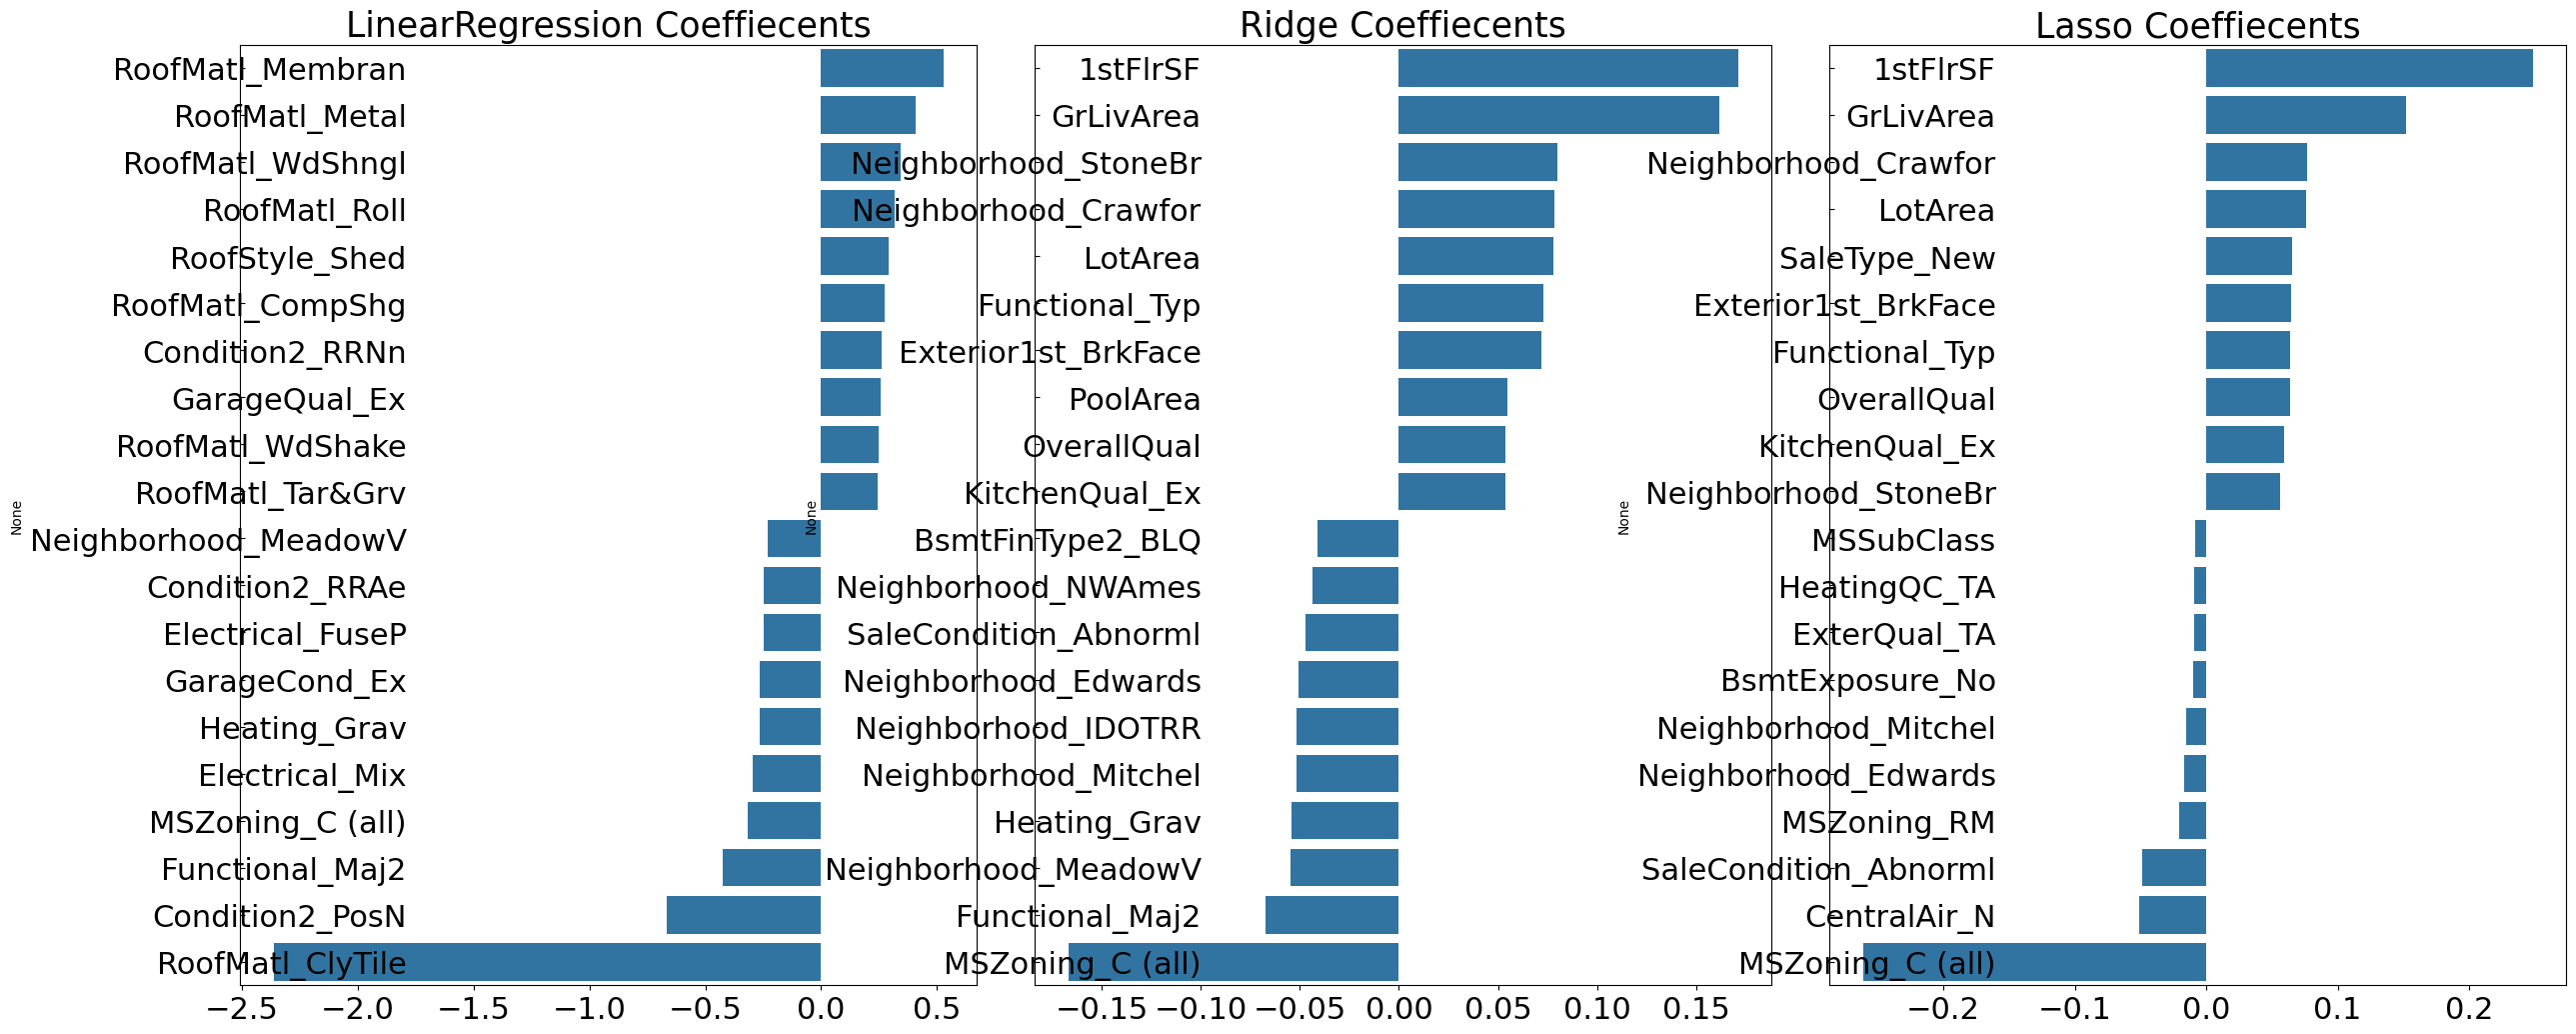

In [ ]:
# 최적화 alpha값으로 학습/예측/평가 수행


# 모든 모델의 RMSE 출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])

# 이상치 제거 전 최적의 alpha 값 적용한 경우
# 릿지 모델 : alpha=10에서 최적 평균 RMSE : 0.122
# 라쏘 모델 : alpha=0.001에서 최적 평균  RMSE : 0.119 

# 이상치 제거 후 최적의 alpha 값 적용한 경우
# 최종 결과
# Ridge RMSE : 0.103
# R제곱 : 0.934
# Lasso RMSE : 0.100
# R제곱 : 0.938



### tip
- 일반적으로 머신러닝 프로세스에서 데이터 전처리는 알고리즘 적용 전에 진행하지만    
- 처음부터 완벽하게 수행할 필요는 없음    
- 대략의 데이터 가공을 진행하고 모델 최적화를 진행한 후    
- 결과를 기반으로 다시 여러 가지 전처리 작업을 진행하는 것이 바람직함  

In [82]:
##################################################################

### 4. 회귀 트리 모델  : LightGBM

선형 회귀
- 회귀 계수를 선형으로 결합하는 회귀 함수를 구해
- 여기에 독립변수를 입력해 결과값을 예측하는 것



회귀 트리
- 회귀 함수를 기반으로 하지 않고
- 트리를 기반으로 하는 회귀 방식
- 분류 트리와 유사하지만
- 리프 노드에서 예측 결정값을 만든 과정에 차이가 있음
- 분류 트리 : 특정 클래스 레이블 결정
- 회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산
    
CART(Classification And Regression Trees) 기반 알고리즘
- 결정트리, 랜덤 포레트스, GBM, XGBoost, LightGBM 등 트리 기반 알고리즘은
- 분류뿐만 아니라 회귀도 가능

### (1) 회귀 트리 모델 생성/학습/예측/평가   
- LightGBM 이용해서 학습/예측/평가 수행

In [83]:
# LightGBM은 분류 수행할 때 수행 속도가 상당히 빠르다는 것을 확인했지만
# 환경에 따라 수행 시간이 오래 걸릴 수 있으므로
# 하이퍼 파라미터 설정을 미리 적용한 상태로
# 5폴드 세트에 대한 평균 RMSE 값 추출

In [84]:
# colsample_bytree=0.5
# - 각 트리(스텝)마다 사용할 피처 샘플링 비율 (0.5~1) (랜덤 샘플)
# - 일부만 샘플링해서 과적합 방지 

# subsample=0.8
# - 각 스텝마다 사용할 학습 데이터의 서브 샘플 비율
# 트리 성장 전 학습 데이터와 일부만 샘플링해서 과적합 방지 

In [ ]:
# LightGBM 회귀 트리 적용

from lightgbm import LGBMRegressor

lgbm_params = {}

lgbm_reg =

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

# LGBMRegressor 회귀 트리 적용 시 
# 5 폴드 세트 평균 RMSE : 0.1166 (colsample_bytree=0.4)
# RMSE : 0.1170,(colsample_bytree=0.5)


# 최종 결과
# Ridge RMSE : 0.103
# R제곱 : 0.934
# Lasso RMSE : 0.100
# R제곱 : 0.938

# LightGBM : RMSE : 0.1166
# 하이퍼 파라미터 튜닝까지 끝내 릿지와 라쏘가 약가 더 성능이 좋음

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3151
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 169
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3163
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 166
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 169
[LightGBM] [Info] Start training from score 12.020683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3175
[LightGBM] [Info] Number of data points in the train set: 1167, number of used features: 166
[LightGBM]

### (2) 피처 중요도 시각화  
- 트리 회귀 모델의 피처 중요도 시각화

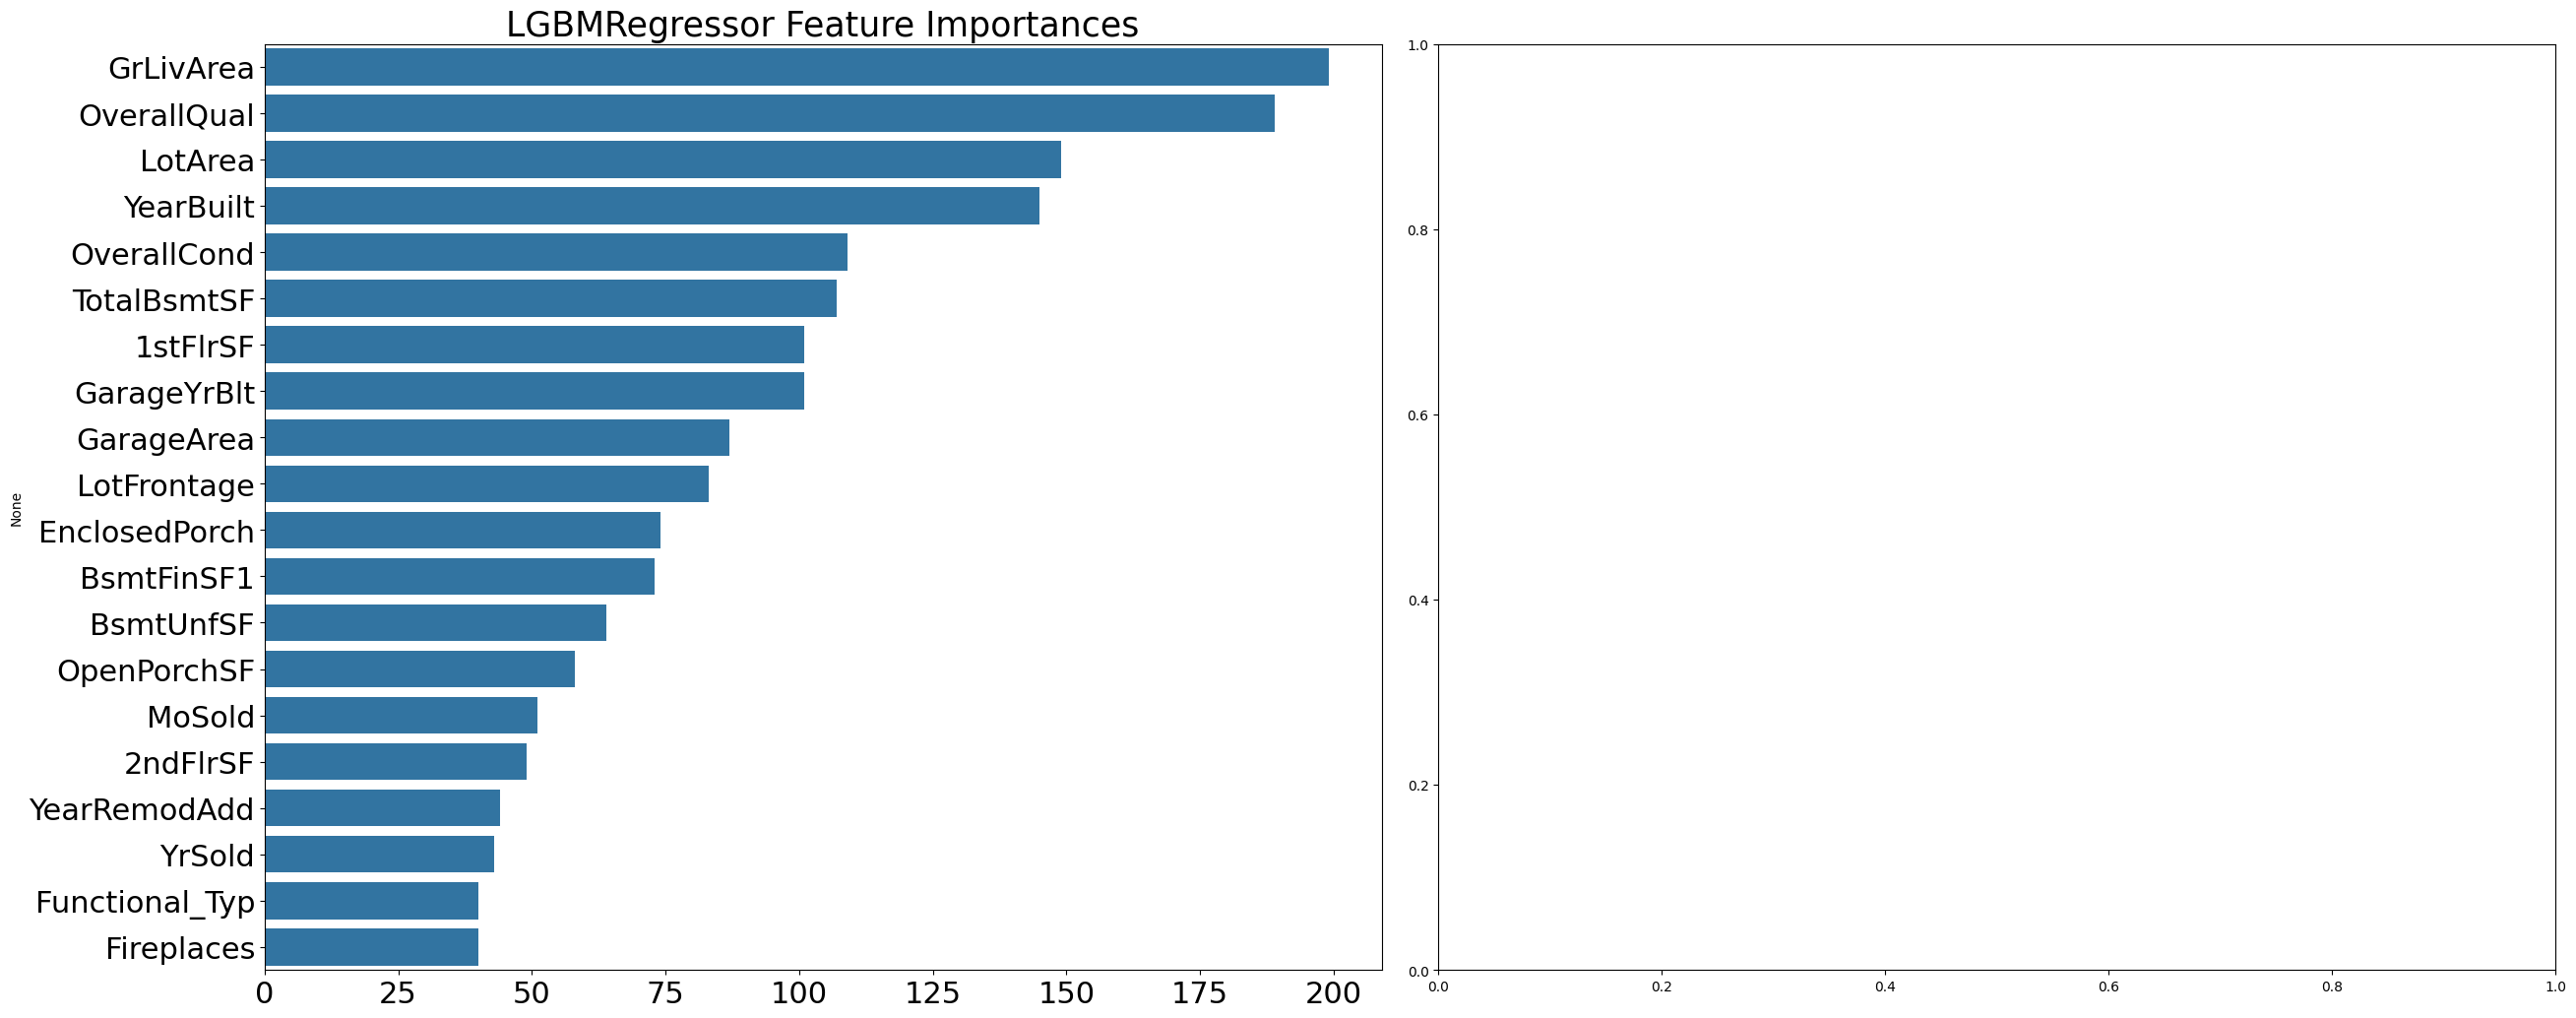

In [86]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_feature.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])
        plt.show()

visualize_ftr_importances([best_lgbm])

In [87]:
# 중요한 피처 확인 
# 트리 계열 : 모델.feature_importances_
# 회귀 : 회귀 계수(coefficient) - 모델.coef_ 속성 

In [88]:
######################################################

### 5. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
-   릿지 모델(40%)과 라쏘 모델(60%) 혼합 

개별 회귀 모델의 예측 결과값을 혼합해서  
이를 기반으로 최종 회귀 값 예측  

예측 결과 혼합 예  
A 모델 , B 모델  
A 모델의 예측값 40%, B 모델의 예측값의 60%를 더해서 최종 회귀값으로 예측  

A :[100, 80, 60]  , B : [120, 80, 50]  
[100$*$0.4 + 120$*$0.6, 80$*$0.4 + 80$*$0.6, 60$*$0.4 + 50$*$0.6]

In [89]:
# 앞에서 진행한 릿지 모델(20%)과 라쏘 모델(80%) 혼합
# 개별 모델과 최종 혼합 모델의 RMSE 확인

# 모델의 RMSE 값 출력하는 함수 작성
def get_rmse_pred(preds):
    for key in preds.keys():
        y_pred = preds[key]
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f'{key} 모델의 RMSE : {rmse:.4f}')       
        

In [ ]:
# 개별 모델 학습



# 개별 모델 예측


# 혼합 모델 
# 개별 모델 예측값 혼합으로 최종 예측값 도출


# 평가 함수 호출
y_preds = {
    '최종 혼합':y_pred,
    'Ridge':ridge_y_pred,
    'Lasso':lasso_y_pred
}

# 모델들의 RMSE 값 출력
get_rmse_pred(y_preds)

# 릿지 + 라쏘 혼합 전 
# Ridge RMSE : 0.103
# R제곱 : 0.934
# Lasso RMSE : 0.100
# R제곱 : 0.938

# 릿지 + 라쏘 혼합 후 
# 릿지(40%) + 라쏘(60%)
# 최종 혼합 모델의 RMSE : 0.1000
# Ridge 모델의 RMSE : 0.1033
# Lasso 모델의 RMSE : 0.100
    
# 릿지(20%) + 라쏘(80%)
# 최종 혼합 모델의 RMSE : 0.0999
# Ridge 모델의 RMSE : 0.1033
# Lasso 모델의 RMSE :0.100

# 결과
# 최종 혼합 모델의 RMSE가 개별 모델보다 성능면에서 약간 개선됨 
# 지금까지 봤던 수치 중 가장 좋은 수치 : 0.0999 (20% + 80%)
# 릿지 모델과 라쏘 모델의 혼합 비율을 정하는 특별한 기준은 없음
# 두 개 모델 중 성능이 약간 좋은 쪽에 가중치를 더 두면 성능이 더 향상됨을 볼 수 있음

# 지금까지 적용한 모델 중
# 혼합 모델의 경우가 성능이 가장 좋게 나왔음

Ridge(alpha=8)

Lasso(alpha=0.001)

최종 혼합 모델의 RMSE : 0.0995
Ridge 모델의 RMSE : 0.1030
Lasso 모델의 RMSE : 0.0999


In [91]:
######################################################################